# 統計学をpythonで実践

## ○サンプルデータの準備

In [148]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from cramersV import cramers_v
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# seabornのサンプルデータの準備。https://github.com/mwaskom/seaborn-data
# githubのtips.csvをロード
# あるレストランで支払われたチップに関するデータ
df = sns.load_dataset('tips')

# 支払額とチップの割合のカラムを追加
df['tip_rate'] = df['tip'] / df['total_bill']
df

,total_bill,tip,sex,smoker,day,time,size,tip_rate
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Male,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,Male,No,Sat,Dinner,2,0.098204


## ○分布の描画

In [12]:
# seabornのバージョン確認。
sns.__version__

'0.11.1'

上記のバージョンだとdistplotではなくdisplotが推奨

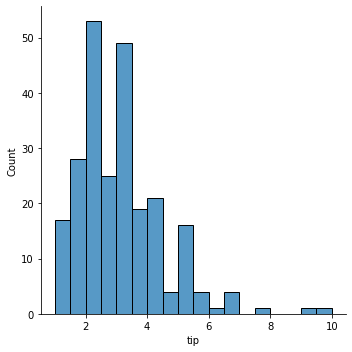

In [14]:
# ヒストグラムの描画
sns.displot(df['tip'])

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


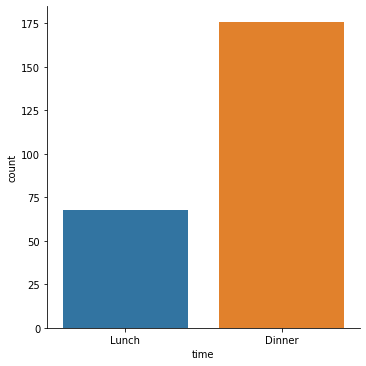

In [15]:
# 棒グラフの描画
sns.catplot('time', data=df, kind='count')

## ○平均値

In [17]:
np.mean([1, 2, 3])

2.0

In [20]:
# Seriesを渡すことも可能
np.mean(df['tip'])

2.9982786885245902

In [21]:
np.mean(df['tip_rate']) 

0.16080258172250478

In [23]:
df['tip_rate'].mean()

0.16080258172250478

In [24]:
# 性別ごとに平均値を見る
df.groupby("sex").mean()

,total_bill,tip,size,tip_rate
sex,,,,
Male,20.744076,3.089618,2.630573,0.157651
Female,18.056897,2.833448,2.459770,0.166491


<AxesSubplot:xlabel='sex', ylabel='tip_rate'>

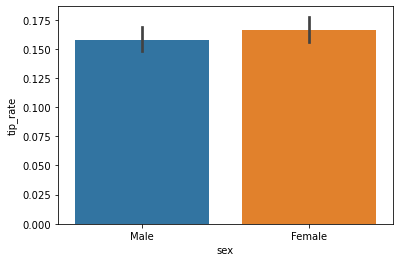

In [26]:
# カテゴリプロット
sns.barplot(x='sex', y='tip_rate', data=df)

何も指定しなくても平均が表示される。これはestimatorという引数のデフォルトがmean関数であるため。  
また、黒の縦棒はエラーバーを示す。消す場合はci=Noneを指定する。

<AxesSubplot:xlabel='sex'>

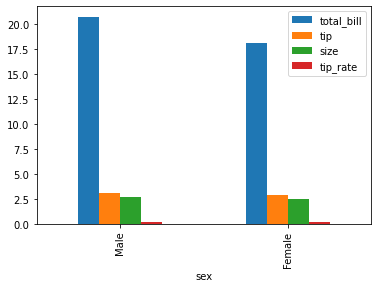

In [28]:
# Seriesから棒グラフを書く
df.groupby("sex").mean().plot(kind='bar')

## ○中央値

In [30]:
np.median([1, 3, 5])

3.0

In [33]:
np.median(df['tip_rate'])

0.15476977125802577

meanが16程度だったのに対してmedianが0.154なので、大きい方に外れ値があると予想される。

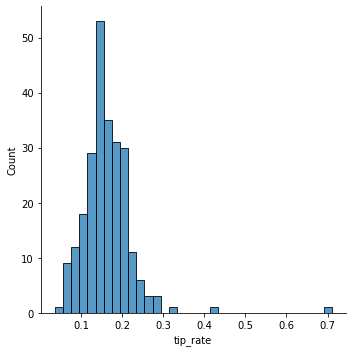

In [34]:
# 分布で確認
sns.displot(df['tip_rate'])

tip_rate=0.7の外れ値がいるので、meanはmedianに対して大きくなってしまう。

In [58]:
# DataFrame.median()でmedianを算出
df['tip_rate'].median()

0.15476977125802577

In [38]:
df.groupby('sex').median()

,total_bill,tip,size,tip_rate
sex,,,,
Male,18.35,3.00,2,0.153492
Female,16.40,2.75,2,0.155581


<AxesSubplot:xlabel='sex', ylabel='tip_rate'>

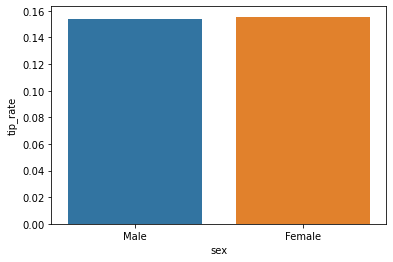

In [40]:
# medianを棒グラフで描画。estimatorにnp.medianを指定する
sns.barplot(x='sex', y='tip_rate', data=df, estimator=np.median, ci=None)

meanの場合と比較すると、Femaleはmedianの方が2%程低く、Maleとほぼ変わらない。  
これは、大きな外れ値があるため。

In [59]:
# 男性と女性ごとのtip_rateを降順に並べる。 
df.sort_values('tip_rate', ascending=False)

,total_bill,tip,sex,smoker,day,time,size,tip_rate
172,7.25,5.15,Male,Yes,Sun,Dinner,2,0.710345
178,9.60,4.00,Female,Yes,Sun,Dinner,2,0.416667
67,3.07,1.00,Female,Yes,Sat,Dinner,1,0.325733
232,11.61,3.39,Male,No,Sat,Dinner,2,0.291990
183,23.17,6.50,Male,Yes,Sun,Dinner,4,0.280535
...,...,...,...,...,...,...,...,...
187,30.46,2.00,Male,Yes,Sun,Dinner,5,0.065660
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
57,26.41,1.50,Female,No,Sat,Dinner,2,0.056797
102,44.30,2.50,Female,Yes,Sat,Dinner,3,0.056433


## ○最頻値を求める
最頻値は下記で求める。科学計算用モジュールのScipy(サイパイ)を使用する。
* stats.mode() : 最頻値とカウントを返す。
* df['column'].mode() : 最頻値をSeriesで返す

In [47]:
stats.mode([1, 2, 2, 2, 3, 4])

ModeResult(mode=array([2]), count=array([3]))

In [50]:
# mode,countがndarrayで返される。それぞれ引数に入れる
mode, count = stats.mode([1, 2, 2, 2, 3, 4])

In [49]:
print(mode, count)

[2] [3]


In [53]:
# DFを入れる
mode, count = stats.mode(df)
df

,total_bill,tip,sex,smoker,day,time,size,tip_rate
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808
...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,0.203927
240,27.18,2.00,Female,Yes,Sat,Dinner,2,0.073584
241,22.67,2.00,Male,Yes,Sat,Dinner,2,0.088222
242,17.82,1.75,Male,No,Sat,Dinner,2,0.098204


In [52]:
print(mode)
print(count)

[[13.42 2.0 'Male' 'No' 'Sat' 'Dinner' 2 0.1448225923244026]]
[[  3  33 157 151  87 176 156   2]]


DFの各カラムに対して、左から順にmode,countがarrayとして返される。  
上記だと、total_billのmodeは13.42でcountは3という意味になる。

In [57]:
# tip_rateカラムの最頻値をSeriesで返す
# 最頻値が複数ある（出てくる回数が同じ）場合のために、Seriesで帰ってくる
df['tip_rate'].mode()

0    0.144823
1    0.153846
dtype: float64

In [56]:
mode, count = stats.mode(df['size'])
print(mode, count)

[2] [156]


来客は二人組の場合が最も多く、156回ということが分かる

## ○範囲(range)

In [60]:
# 最小値を求める
np.min(df['tip'])

1.0

In [62]:
df['tip'].min()

1.0

In [63]:
df.groupby('sex').min()

,total_bill,tip,size,tip_rate
sex,,,,
Male,7.25,1.0,1,0.035638
Female,3.07,1.0,1,0.056433


In [64]:
# 最大値を求める
np.max(df['tip'])

10.0

In [65]:
df['tip'].max()

10.0

In [66]:
df.groupby('sex').max()

,total_bill,tip,size,tip_rate
sex,,,,
Male,50.81,10.0,6,0.710345
Female,44.30,6.5,6,0.416667


In [69]:
# 範囲を求める（あまり使うことはない）
np.max(df['tip']) - np.min(df['tip'])

9.0

## ○四分位数を求める 

In [75]:
# np.quantileで求める。これは四分位数ではなく分位数なので、25%,50%,75%を指定する必要がある。
# 任意の分位数を求めることができる
np.quantile(df['tip_rate'], [0.25, 0.5, 0.75])

array([0.12912736, 0.15476977, 0.19147549])

In [74]:
df['tip_rate'].quantile([0.25, 0.5, 0.75])

0.25    0.129127
0.50    0.154770
0.75    0.191475
Name: tip_rate, dtype: float64

In [76]:
# 四分位範囲をもとめる
stats.iqr(df['tip_rate'])

0.06234812458689151

In [77]:
0.191475 - 0.129127

0.062348000000000015

In [79]:
# 四分位偏差を求める
stats.iqr(df['tip_rate']) / 2

0.031174062293445756

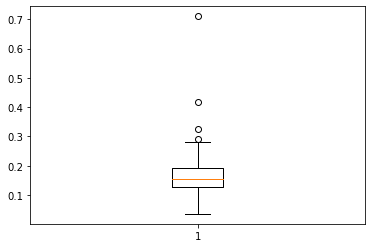

In [83]:
# 箱ひげ図も見てみる
plt.boxplot(df['tip_rate'])
plt.show()

ひげをどの範囲で書くかはケースバイケース。whis引数で指定できる。デフォルトではIQRの1.5倍。

<AxesSubplot:xlabel='size', ylabel='tip_rate'>

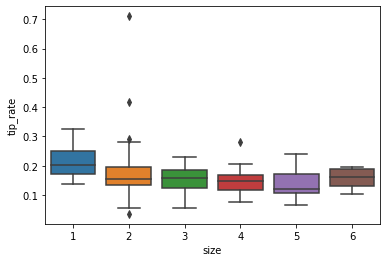

In [86]:
# seabornでboxplotを表示
sns.boxplot(x='size', y='tip_rate', data=df )

人数が多いほどtip_rateが下がる傾向にあることがわかる。  
これは人数が多いとtotal_billが上がるため、少人数の時のtip_rateと同じだと支払うチップ額が大きくなってしまうためセーブするからだと考えられる。

## ○分散と標準偏差

In [87]:
# np.var():分散を算出
np.var([1, 2, 3, 4])

1.25

In [99]:
np.var(df['tip'])

1.9066085124966428

In [88]:
np.var(df['tip_rate'])

0.0037145280013546928

In [89]:
# np.std():標準偏差を算出
np.std(df['tip'])

1.3807999538298958

In [91]:
np.mean(df['tip'])

2.9982786885245902

tip額の平均が約3,標準偏差が1.4ぐらいなので、仮に正規分布になっているなら  
68-95-99.7則に従い、tip額が1.6-4.4の間に全データの68%が入っていると予想される。

In [90]:
# varのルートをとると同じ。
np.sqrt(np.var(df['tip']))

1.3807999538298958

## ○共分散

In [102]:
# x=[1, 2, 3],y=[-4, 5, 6]の共分散行列を求める
# デフォルトではnではなく、n-1で割った不偏分散で計算される。
# nで割るにはbias=Trueにする。
np.cov([1, 2, 3], [-4, 5, 6], bias=True)

array([[ 0.66666667,  3.33333333],
       [ 3.33333333, 20.22222222]])

In [103]:
# x=df['total_bill'],y=df['tip']の共分散行列を求める
np.cov(df['total_bill'], df['tip'], bias=True)

array([[78.92813149,  8.28938892],
       [ 8.28938892,  1.90660851]])

In [111]:
# 3つ以上の変数を扱う場合はstackで結合する。
# Seriesを3行に並べるならば、axis=0。Seriesは1次元配列。
x = np.stack([df['total_bill'],df['tip'], df['size']], axis=0)
x

array([[16.99, 10.34, 21.01, 23.68, 24.59, 25.29,  8.77, 26.88, 15.04,
        14.78, 10.27, 35.26, 15.42, 18.43, 14.83, 21.58, 10.33, 16.29,
        16.97, 20.65, 17.92, 20.29, 15.77, 39.42, 19.82, 17.81, 13.37,
        12.69, 21.7 , 19.65,  9.55, 18.35, 15.06, 20.69, 17.78, 24.06,
        16.31, 16.93, 18.69, 31.27, 16.04, 17.46, 13.94,  9.68, 30.4 ,
        18.29, 22.23, 32.4 , 28.55, 18.04, 12.54, 10.29, 34.81,  9.94,
        25.56, 19.49, 38.01, 26.41, 11.24, 48.27, 20.29, 13.81, 11.02,
        18.29, 17.59, 20.08, 16.45,  3.07, 20.23, 15.01, 12.02, 17.07,
        26.86, 25.28, 14.73, 10.51, 17.92, 27.2 , 22.76, 17.29, 19.44,
        16.66, 10.07, 32.68, 15.98, 34.83, 13.03, 18.28, 24.71, 21.16,
        28.97, 22.49,  5.75, 16.32, 22.75, 40.17, 27.28, 12.03, 21.01,
        12.46, 11.35, 15.38, 44.3 , 22.42, 20.92, 15.36, 20.49, 25.21,
        18.24, 14.31, 14.  ,  7.25, 38.07, 23.95, 25.71, 17.31, 29.93,
        10.65, 12.43, 24.08, 11.69, 13.42, 14.26, 15.95, 12.48, 29.8 ,
      

In [113]:
x.shape

(3, 244)

In [114]:
# 3つの変数なので、３×３になる。
np.cov(x, bias=True)

array([[78.92813149,  8.28938892,  5.04522121],
       [ 8.28938892,  1.90660851,  0.64126747],
       [ 5.04522121,  0.64126747,  0.9008835 ]])

In [115]:
# dfの不偏共分散行列を求める。
df.cov()

,total_bill,tip,size,tip_rate
total_bill,79.252939,8.323502,5.065983,-0.184107
tip,8.323502,1.914455,0.643906,0.028931
size,5.065983,0.643906,0.904591,-0.008298
tip_rate,-0.184107,0.028931,-0.008298,0.003730


## ○相関係数

In [117]:
# 相関行列を算出
np.corrcoef(df['total_bill'],df['tip'])

array([[1.        , 0.67573411],
       [0.67573411, 1.        ]])

In [118]:
# 3つ以上の変数の場合は共分散と同様にstackしてから入れる
x = np.stack([df['total_bill'],df['tip'], df['size']], axis=0)
np.corrcoef(x)

array([[1.        , 0.67573411, 0.59831513],
       [0.67573411, 1.        , 0.48929878],
       [0.59831513, 0.48929878, 1.        ]])

共分散では各2変数間の比較ができなかったが、相関係数は標準化されているため、比較可能。  
上記では、total_billとtipの相関が他の2変数との相関に比べて高いことがわかる。  
また、全て正なので正の相関があることが分かる。

In [119]:
# dfの各カラムに対して相関係数を表示
df.corr()

,total_bill,tip,size,tip_rate
total_bill,1.000000,0.675734,0.598315,-0.338624
tip,0.675734,1.000000,0.489299,0.342370
size,0.598315,0.489299,1.000000,-0.142860
tip_rate,-0.338624,0.342370,-0.142860,1.000000


total_billとtip_rateは負の相関になっている。  
これはお会計が高くなるほど、tipとして支払う金額の割合が小さくなることを示している。

<AxesSubplot:>

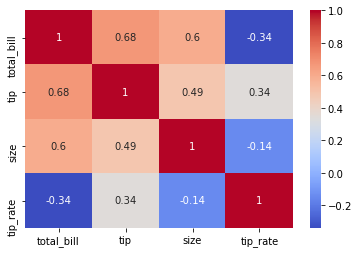

In [123]:
# heatmapで表示
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)

## ○連関

In [128]:
# pd.crosstab:2つのカテゴリ変数を渡し、クロス表（分割表）をDataFrameで返す
# 第１引数はインデックス、第２引数はカラムになる
pd.crosstab(df['sex'], df['time'])

time,Lunch,Dinner
sex,,
Male,33,124
Female,35,52


In [130]:
# カイ二乗値と期待度数を求める。
cont_table = pd.crosstab(df['sex'], df['time'])
stats.chi2_contingency(cont_table, correction=False)

(10.277251918677742,
 0.0013468039268008766,
 1,
 array([[ 43.75409836, 113.24590164],
        [ 24.24590164,  62.75409836]]))

第１戻り値がカイ二乗値、第４引数が期待度数の分割表になる。correction,第２，３引数については後述。

## ○クラメールの連関係数
主要なライブラリにはないので、自分で作る。

In [153]:
# 事前確認
# df.shapeで行数、列数がタプルで返される　
cont_table.shape

(2, 2)

In [156]:
# minまたはnp.minで小さい方が返される。
min(cont_table.shape)

2

In [157]:
# クラメールの連関係数を算出
cramers_v(df['sex'], df['time'])

0.20523129613344476

## ○確率分布
scipyのstatsモジュールには様々な確率分布が含まれている。

In [169]:
# 一様分布（整数）からランダムなデータを生成。とびとびの値をとる（離散型）
# rvs: random variatesの略。確率変量（確率変数の実際の値。サイコロの目。１とか）
# 1-6のランダムな整数を生成する。ちょうどサイコロと同じ。(1,7)はrandintでもrvsどっちに入れてもよい。
stats.randint(1, 7).rvs()

4

In [167]:
# 1-6が出る期待値を算出
stats.randint(1, 7).mean()

3.5

In [170]:
# 一様分布（実数の範囲で）からランダムなデータを生成。（連続型）
stats.uniform.rvs(0, 1)

0.25048700415745195

## ○確率分布の描画

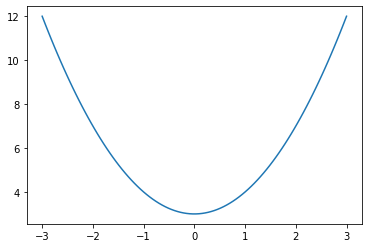

In [174]:
# おさらい：普通の関数の描画

# xの目盛を用意
x = np.linspace(-3, 3, 100)

# 関数を定義
y = lambda x: x**2 + 3

# 描画
plt.plot(x, y(x))

In [187]:
# 離散型の一様分布に対し、pmf(1)で1が出る確率を求める。確率変数に1を入れて、そのときの確率を算出している。
# .pmfはrandintで定義した確率分布の関数にアクセスするイメージ
stats.randint(1, 7).pmf(1)

0.16666666666666666

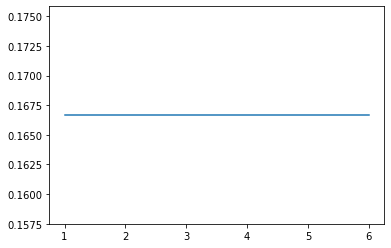

In [181]:
# 離散型の場合はnp.arangeでxを用意
x = np.arange(1, 7)

# 縦軸を定義
y = stats.randint(1, 7).pmf(x)

plt.plot(x, y)

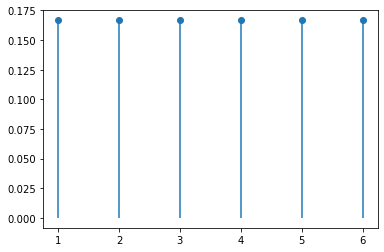

In [184]:
# 上記だと連続的に見えてしまうので、'o'を指定して離散的に表示する。
plt.plot(x, y, 'o')

# 縦線を描画
plt.vlines(x, 0, y)

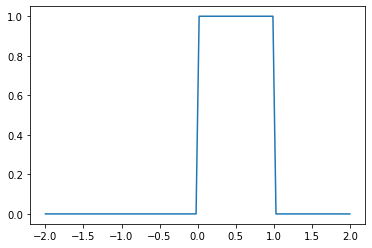

In [186]:
# 連続型の確率分布を描画
x = np.linspace(-2, 2, 100)

# 0-1の範囲で連続的な値を返す確率分布を定義し、pdfで関数に値を入れる。
y = stats.uniform(loc=0, scale=1).pdf(x)
plt.plot(x, y)

0-1で一様分布を定義したので、これ以外の範囲の値をとることはない（確率ゼロ）。  
範囲内の値をとるとき必ず縦軸の値(.pdf()の戻り値)が1となるのは、確率密度関数の性質を考えると当然で、面積が1になるように高さが決まるため。  
.pdf(x)の戻り値はある値xにおける確率密度関数の縦軸の値を返すだけであり、確率ではない。あまり意味はない。大事なのは面積。

In [190]:
stats.uniform(loc=0, scale=1).pdf(0.5)

1.0

## ○累積分布関数(CDF)

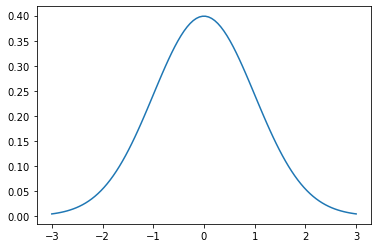

In [198]:
# 正規分布のPDFを描画する
x = np.linspace(-3, 3, 100)
y = stats.norm.pdf(x)
plt.plot(x, y)

In [194]:
# 正規分布とCDFを描画する
x = np.linspace(-3, 3, 100)
y = stats.norm.cdf(x)
y

array([0.0013499 , 0.00164427, 0.00199603, 0.00241482, 0.00291159,
       0.00349868, 0.00418999, 0.00500104, 0.00594906, 0.00705314,
       0.00833425, 0.00981533, 0.01152131, 0.01347915, 0.01571778,
       0.01826811, 0.02116287, 0.02443656, 0.02812518, 0.03226612,
       0.03689778, 0.04205935, 0.04779035, 0.0541303 , 0.06111818,
       0.06879198, 0.07718815, 0.08634102, 0.09628221, 0.10704004,
       0.11863893, 0.13109879, 0.14443448, 0.15865525, 0.17376426,
       0.18975815, 0.20662669, 0.2243525 , 0.24291088, 0.26226972,
       0.28238953, 0.30322357, 0.32471814, 0.34681289, 0.36944134,
       0.39253143, 0.41600624, 0.43978468, 0.46378241, 0.48791269,
       0.51208731, 0.53621759, 0.56021532, 0.58399376, 0.60746857,
       0.63055866, 0.65318711, 0.67528186, 0.69677643, 0.71761047,
       0.73773028, 0.75708912, 0.7756475 , 0.79337331, 0.81024185,
       0.82623574, 0.84134475, 0.85556552, 0.86890121, 0.88136107,
       0.89295996, 0.90371779, 0.91365898, 0.92281185, 0.93120

↑確率が左から積みあがっていく様子が分かる。

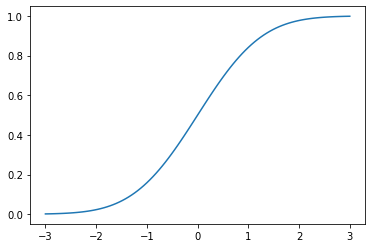

In [195]:
plt.plot(x, y)

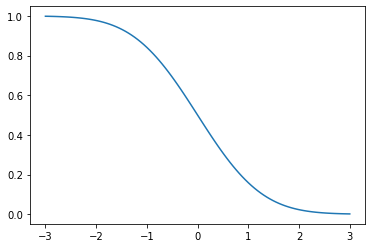

In [197]:
# 1-CDF（確率密度関数の右側の面積）を求める.sf: survival function
y = stats.norm.sf(x)
plt.plot(x, y)

cdfと対称になる。

## ○正規分布
stats.norm(loc,scale)で任意の正規分布が書ける。  
locは平均（頂点のx座標）、scaleは標準偏差（分布の幅）を指定する。  
※標準偏差を指定すれば分散は求まるため

In [202]:
# rvsで分布からランダムに値を取り出す。
stats.norm(loc=10, scale=3).rvs() 

9.508795029105347

大体10付近の値が返ってくる

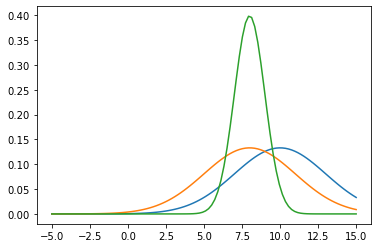

In [207]:
x = np.linspace(-5 , 15, 100)
y = stats.norm(loc=10, scale=3).pdf(x)
y2 = stats.norm(loc=8, scale=3).pdf(x)
y3 = stats.norm(loc=8, scale=1).pdf(x)
plt.plot(x, y)
plt.plot(x, y2)
plt.plot(x, y3)

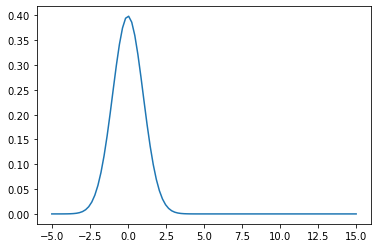

In [209]:
y = stats.norm.pdf(x)
plt.plot(x, y)

normの引数に何も指定しないと平均0、標準偏差1の正規分布になる。  
これは標準正規分布という。

## ○カーネル密度推定(KDE)

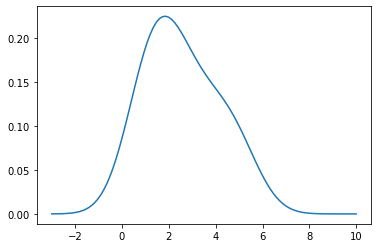

In [215]:
x = np.linspace(-3, 10, 100)
y = stats.gaussian_kde([1, 1, 2, 2, 3, 4, 5]).pdf(x)
plt.plot(x,y)

データが多い1,2周辺が確率が高くなっている。  
kdeをすると、サンプリングデータ(1-5)以外の範囲についても描かれる。  

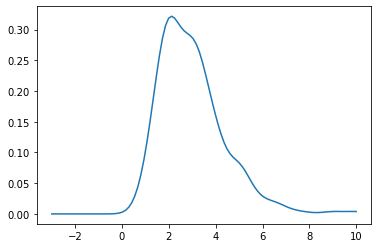

In [217]:
# tipの確率密度分布を推定する
y = stats.gaussian_kde(df['tip']).pdf(x)
plt.plot(x,y)

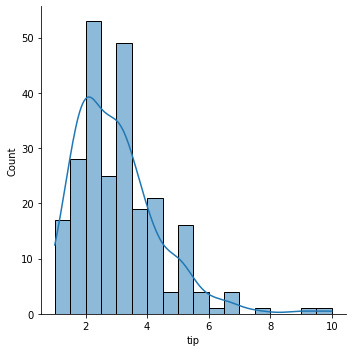

In [219]:
# ヒストグラムと一緒にkdeによる確率密度分布を表示する
sns.displot(df['tip'], kde=True)

ヒストグラムだけでなく確率密度分布を求めることで、より統計的に信頼性のある知見が得られることがある。

In [239]:
# 求めた確率分布からランダムに値を生成する。
resample_data = stats.gaussian_kde(df['tip']).resample()

In [240]:
resample_data

array([[ 6.35035236,  3.38380281,  3.55139598,  4.33758783,  5.30665396,
         2.60063009,  2.83564205,  6.32041388,  1.44510438,  5.81451341,
         2.13052841,  1.79387644,  1.81723561,  1.57938693,  7.11941029,
         3.46719355,  4.97264557,  1.94215404,  3.27373545,  4.18307825,
         0.72842941,  2.02550996,  1.61460758,  4.3315044 ,  2.55714435,
         1.47627142,  2.26599213,  1.56944149,  2.36502894,  3.38720105,
         2.67761556,  2.53809037,  3.47407985,  2.76999184,  6.05961869,
         1.83829629,  4.49160855,  3.09442269,  4.40341335,  2.78427963,
         3.45547607,  4.18279892,  3.0765918 ,  4.35705261,  2.74494503,
         3.03674397,  2.6185413 ,  1.42679997,  1.65248674,  2.02709388,
         3.72511532,  4.73784373,  6.06613242,  1.87151401,  2.15431299,
         2.50728037,  3.36601536,  3.03148826,  2.24480187,  2.32588224,
         1.246793  ,  4.54761604,  2.46472726,  3.40689055,  5.72898146,
         1.15478669,  8.90261263,  1.33195748,  3.0

元のデータ数と同じ分だけ返ってくる。  
サンプリングデータの中にゼロなどの境界線に近いデータがあると、そのデータを中心としたカーネルの重ね合わせにより、  
tipが負になるなど境界を超えてしまうことがある。  
これを避けるために、ミラーリングさせる。
